# Fine tunned

In [ ]:
import json
import logging
from tqdm import tqdm

from llamafactory.chat import ChatModel
from llamafactory.extras.misc import torch_gc
from src.utils import extract_sql, chdiff
from src.levenshtein import levenshtein_distance
from src.judge import SqlJudge

logging.disable(logging.WARNING)

BASE_MODEL_PATH = "Qwen/Qwen3-0.6B"
ADAPTER_PATH = "out/checkpoint-1500"
DATASET_PATH = "data/dataset_test.json"
SYSTEM_PROMPT_INDEX = 0
MAX_TEST_SIZE = 500
VERBOSE = False 

with open(DATASET_PATH, "r") as f:
    test_ds = json.load(f)

system_prompt = test_ds[SYSTEM_PROMPT_INDEX]["system"]


args = dict(
    model_name_or_path=BASE_MODEL_PATH,
    adapter_name_or_path=ADAPTER_PATH,
    template="qwen3",
    finetuning_type="lora"
)
chat_model = ChatModel(args)

sql_judge: SqlJudge = SqlJudge()

def print_color(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m", end="", flush=True)

def print_red(text): print_color(text, 91)
def print_green(text): print_color(text, 92)
def print_yellow(text): print_color(text, 93)

def evaluate_entry(entry, system_prompt, verbose=False):
    user_prompt = entry["conversations"][0]["value"]
    true_sql = extract_sql(entry["conversations"][1]["value"])

    if verbose:
        print_green(f"\nUser:\n{user_prompt}")
        print_yellow("\nAssistant: ")

    response = ""
    messages = [{"role": "user", "content": user_prompt}]
    for chunk in chat_model.stream_chat(messages, system=system_prompt):
        if verbose:
            print_yellow(chunk)
        response += chunk

    predicted_sql = extract_sql(response)
    exact_match = (predicted_sql == true_sql)
    distance = levenshtein_distance(predicted_sql, true_sql)
    judge_score = sql_judge.score_response(true_sql, predicted_sql)

    if verbose:
        if exact_match:
            print_green("\n\nExact match!")
        print("\nDiff:\n", chdiff(true_sql, predicted_sql), "\n")

    return exact_match, distance, len(true_sql), judge_score

exact_match_count = 0
levenshtein_metrics = []
judge_scores = []

print(f"Evaluating {min(MAX_TEST_SIZE, len(test_ds))} examples...\n")


if VERBOSE:
    print_red(f"\nSystem:\n{system_prompt}")

for entry in tqdm(test_ds[:MAX_TEST_SIZE]):
    match, dist, query_len, judge_score = evaluate_entry(entry, system_prompt, verbose=VERBOSE)
    if match:
        exact_match_count += 1
    levenshtein_metrics.append({"query_length": query_len, "distance": dist})
    judge_scores.append(judge_score)
    torch_gc()

print("\n=== Evaluation Summary ===")
print(f"Exact Match: {exact_match_count}/{MAX_TEST_SIZE} "
        f"({(exact_match_count / MAX_TEST_SIZE) * 100:.2f}%)")

avg_lev = sum(m["distance"] for m in levenshtein_metrics) / len(levenshtein_metrics)
print(f"Average Levenshtein Distance: {avg_lev:.2f}")


Evaluating 500 examples...



  1%|          | 4/500 [01:13<2:20:17, 16.97s/it]

In [ ]:
print(exact_match_count, "exact matches out of", MAX_TEST_SIZE)

126 exact matches out of 500


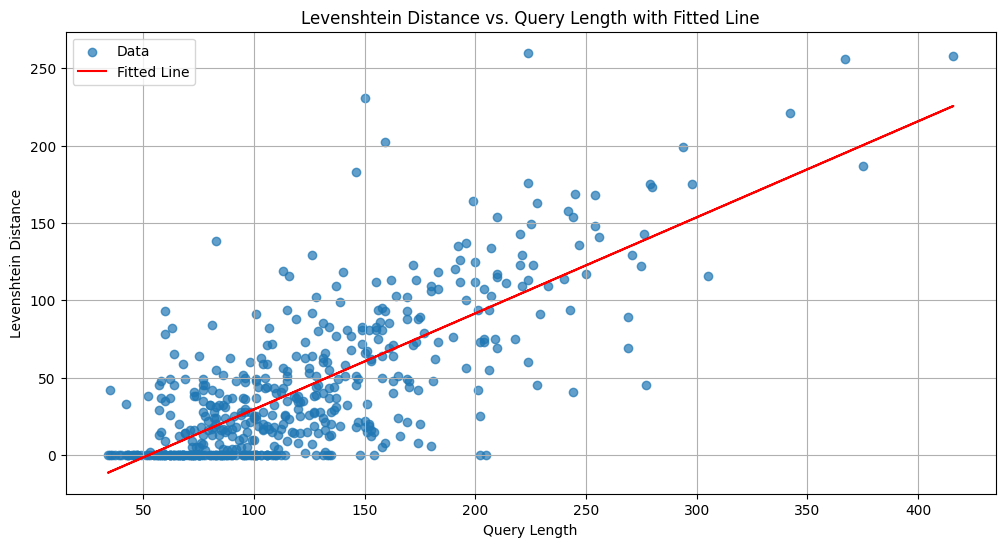

Slope: 0.6205852757861957
Intercept: -32.570112030863704
R-value: 0.7542669818565523
P-value: 4.788157335974516e-93
Standard error: 0.02420701843903765


In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

query_lengths = [m["query_length"] for m in levenshtein_metrics]
distances = [m["distance"] for m in levenshtein_metrics]

x = query_lengths
y = distances

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

def linear_func(x):
    return slope * np.array(x) + intercept

plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.7, label="Data")
plt.plot(x, linear_func(x), color='red', label="Fitted Line")

plt.title("Levenshtein Distance vs. Query Length with Fitted Line")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.legend()
plt.grid(True)
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard error:", std_err)

In [ ]:
plt.hist(judge_scores, bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Judge Scores")
plt.xlabel("Judge Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()
print("Average Judge Score:", np.mean(judge_scores))
print("Median Judge Score:", np.median(judge_scores))
print("Standard Deviation of Judge Scores:", np.std(judge_scores))
print("Minimum Judge Score:", np.min(judge_scores))
print("Maximum Judge Score:", np.max(judge_scores))

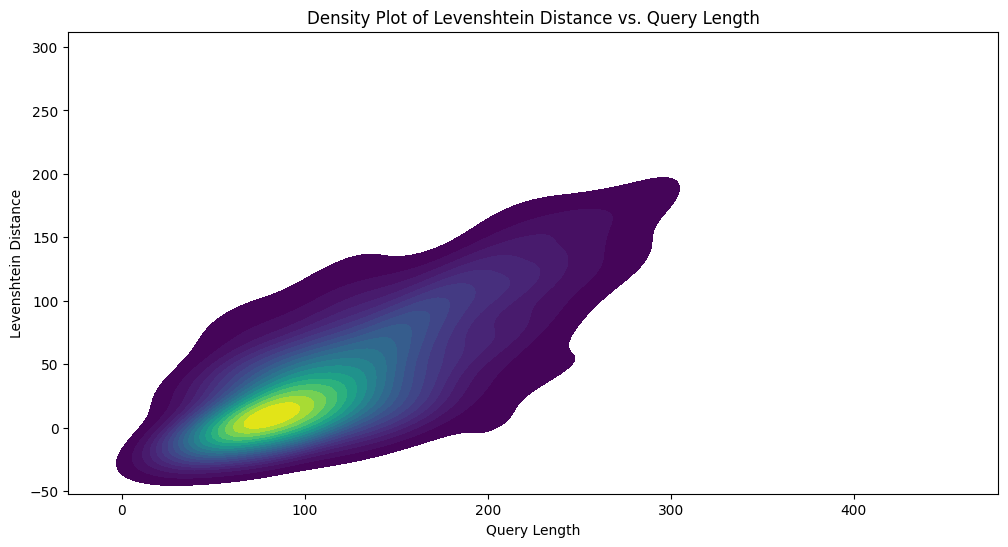

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(x=query_lengths, y=distances, fill=True, cmap="viridis", thresh=0.05, levels=20)
plt.title("Density Plot of Levenshtein Distance vs. Query Length")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.show()

# Base model


In [ ]:
import json
import logging
from tqdm import tqdm

from llamafactory.chat import ChatModel
from llamafactory.extras.misc import torch_gc
from src.utils import extract_sql, chdiff
from src.levenshtein import levenshtein_distance

logging.disable(logging.WARNING)

BASE_MODEL_PATH = "Qwen/Qwen3-0.6B"
ADAPTER_PATH = "out/checkpoint-1500"
DATASET_PATH = "data/dataset_test.json"
SYSTEM_PROMPT_INDEX = 0
MAX_TEST_SIZE = 500
VERBOSE = False 

with open(DATASET_PATH, "r") as f:
    test_ds = json.load(f)

system_prompt = test_ds[SYSTEM_PROMPT_INDEX]["system"]


args = dict(
    model_name_or_path=BASE_MODEL_PATH,
    template="qwen3",
    finetuning_type="lora"
)
chat_model = ChatModel(args)

def print_color(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m", end="", flush=True)

def print_red(text): print_color(text, 91)
def print_green(text): print_color(text, 92)
def print_yellow(text): print_color(text, 93)

def evaluate_entry(entry, system_prompt, verbose=False):
    user_prompt = entry["conversations"][0]["value"]
    true_sql = extract_sql(entry["conversations"][1]["value"])

    if verbose:
        print_green(f"\nUser:\n{user_prompt}")
        print_yellow("\nAssistant: ")

    response = ""
    messages = [{"role": "user", "content": user_prompt}]
    for chunk in chat_model.stream_chat(messages, system=system_prompt):
        if verbose:
            print_yellow(chunk)
        response += chunk

    predicted_sql = extract_sql(response)
    exact_match = (predicted_sql == true_sql)
    distance = levenshtein_distance(predicted_sql, true_sql)

    if verbose:
        if exact_match:
            print_green("\n\nExact match!")
        print("\nDiff:\n", chdiff(true_sql, predicted_sql), "\n")

    return exact_match, distance, len(true_sql)

exact_match_count = 0
levenshtein_metrics = []

print(f"Evaluating {min(MAX_TEST_SIZE, len(test_ds))} examples...\n")


if VERBOSE:
    print_red(f"\nSystem:\n{system_prompt}")

for entry in tqdm(test_ds[:MAX_TEST_SIZE]):
    match, dist, query_len = evaluate_entry(entry, system_prompt, verbose=VERBOSE)
    if match:
        exact_match_count += 1
    levenshtein_metrics.append({"query_length": query_len, "distance": dist})
    torch_gc()

print("\n=== Evaluation Summary ===")
print(f"Exact Match: {exact_match_count}/{MAX_TEST_SIZE} "
        f"({(exact_match_count / MAX_TEST_SIZE) * 100:.2f}%)")

avg_lev = sum(m["distance"] for m in levenshtein_metrics) / len(levenshtein_metrics)
print(f"Average Levenshtein Distance: {avg_lev:.2f}")


Evaluating 500 examples...



100%|██████████| 500/500 [21:06<00:00,  2.53s/it] 


=== Evaluation Summary ===
Exact Match: 34/500 (6.80%)
Average Levenshtein Distance: 60.74


In [ ]:
print(exact_match_count, "exact matches out of", MAX_TEST_SIZE)

34 exact matches out of 500


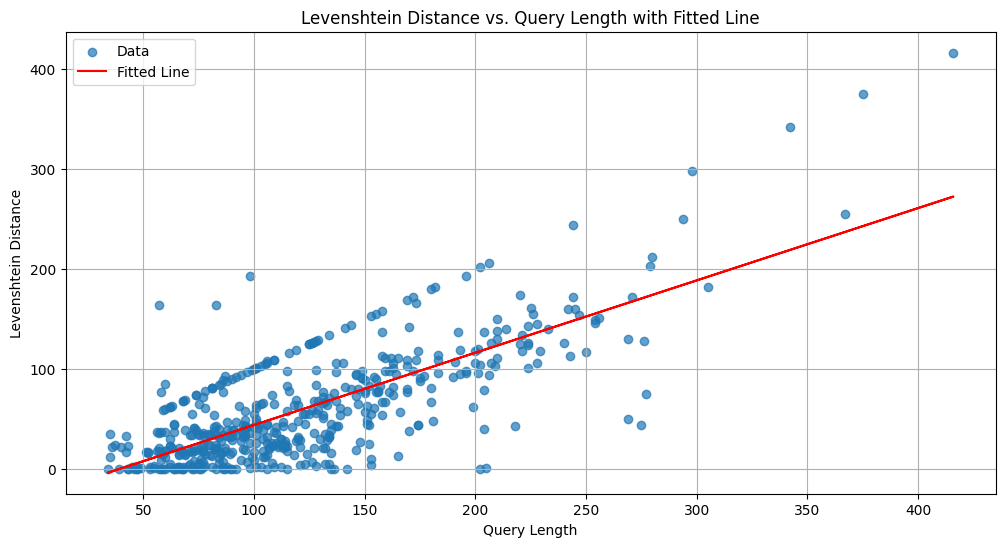

Slope: 0.722311618209575
Intercept: -28.20289728956348
R-value: 0.7544825679129297
P-value: 3.966610942324503e-93
Standard error: 0.028156353843173814


In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

query_lengths = [m["query_length"] for m in levenshtein_metrics]
distances = [m["distance"] for m in levenshtein_metrics]

x = query_lengths
y = distances

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

def linear_func(x):
    return slope * np.array(x) + intercept

plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.7, label="Data")
plt.plot(x, linear_func(x), color='red', label="Fitted Line")

plt.title("Levenshtein Distance vs. Query Length with Fitted Line")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.legend()
plt.grid(True)
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard error:", std_err)

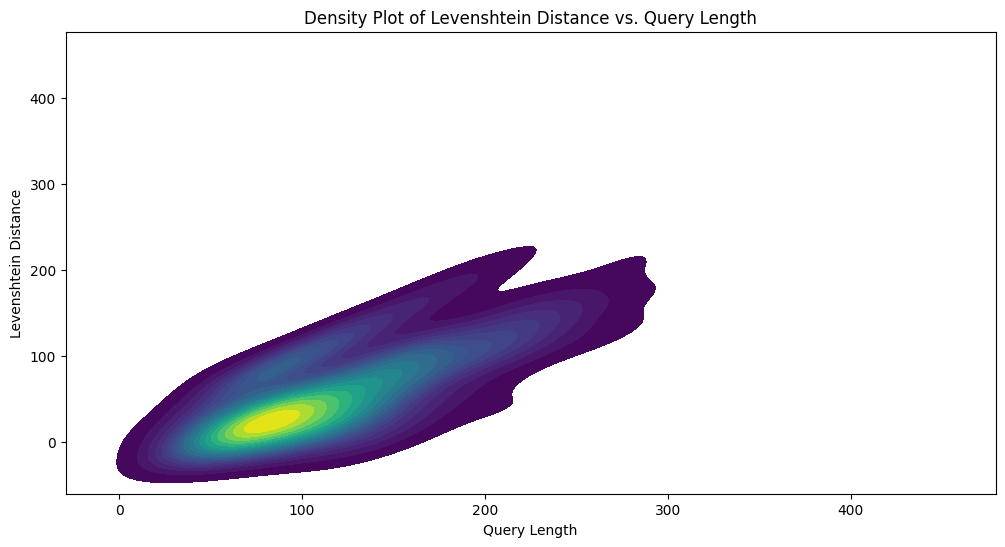

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(x=query_lengths, y=distances, fill=True, cmap="viridis", thresh=0.05, levels=20)
plt.title("Density Plot of Levenshtein Distance vs. Query Length")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.show()